In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import glob

In [2]:
nc_files = sorted(glob.glob("C:/Users\locfa_v05v5qi/Documents/escadas_termohalinas/raw/Dataset/**/*.nc", recursive=True))

In [3]:
def subset_region(ds):

    # Ajustar longitudes se estiverem em 0–360
    if float(ds.lon.max()) > 180:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        )

    mask = (
        (ds.lat <= 10) & (ds.lat >= -60) &
        (ds.lon >= -50) & (ds.lon <= -10)
    )

    if "Nobs" in ds.dims:
        ds = ds.isel(Nobs=mask)

    return ds

In [8]:
dc_pure_data = {
    "lat": [],
    "depth": [],
    "thickness": []
}

for fname in nc_files:
    try:
        ds = xr.open_dataset(fname)
        ds = subset_region(ds)

        nobs = ds.sizes.get("Nobs", 0)
        if nobs == 0:
            ds.close()
            continue

        for i in range(nobs):

            lat = float(ds.lat[i])

            sf_mask = ds.mask_ml_sf_layer[i, :].values
            dc_mask = ds.mask_ml_dc_layer[i, :].values
            idx_sf = np.where(sf_mask > 0)[0]
            idx_dc = np.where(dc_mask > 0)[0]
            
            if len(idx_dc) > 0 and len(idx_sf) == 0:
                for j in idx_dc:
                    depth = float(ds.ml_p[i, j])
                    thickness = float(ds.ml_h[i, j])
    
                    dc_pure_data["lat"].append(lat)
                    dc_pure_data["depth"].append(depth)
                    dc_pure_data["thickness"].append(thickness)

        ds.close()

    except Exception as e:
        print("Erro em", fname, "->", e)


In [ ]:
df_dc_pure = pd.DataFrame(dc_pure_data)

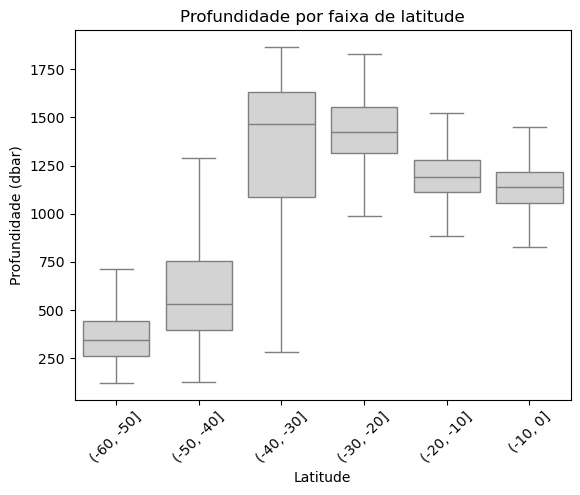

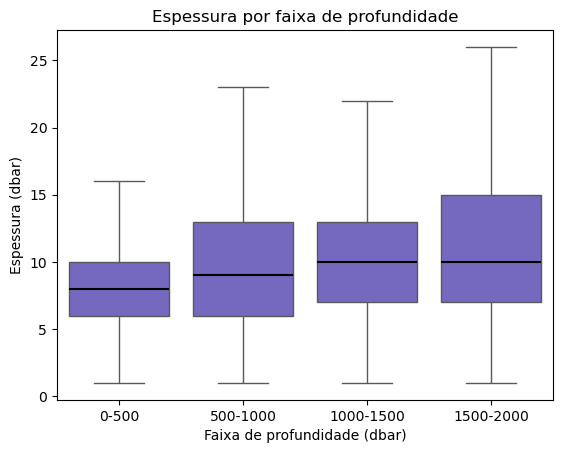

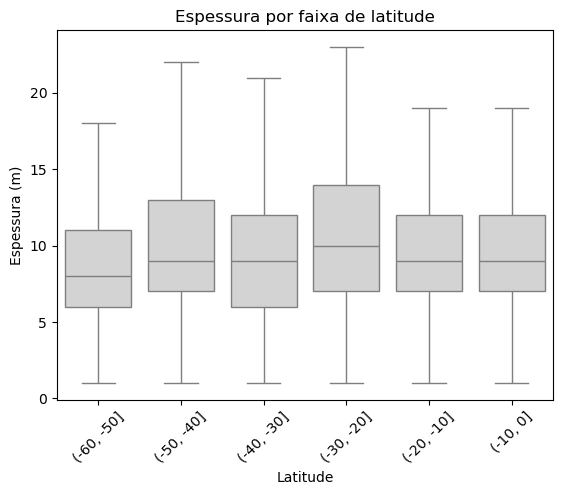

In [39]:
df_dc_pure["lat_bin"] = pd.cut(
    df_dc_pure["lat"],
    bins=np.arange(-60, 10, 10)
)

df_dc_pure["depth_bin"] = pd.cut(
    df_dc_pure["depth"],
    bins=[0, 500, 1000, 1500, 2000],
    labels=["0-500", "500-1000", "1000-1500", "1500-2000"]
)

plt.figure()
sns.boxplot(data=df_dc_pure, x="lat_bin", y="depth", color="lightgrey", showfliers=False)
plt.xticks(rotation=45)
plt.title("Profundidade por faixa de latitude")
plt.xlabel("Latitude")
plt.ylabel("Profundidade (dbar)")
plt.show()

plt.figure()
sns.boxplot(
    data=df_dc_pure,
    x="depth_bin",
    y="thickness",
    color="slateblue",
    showfliers=False,
    medianprops=dict(color="black", linewidth=1.5)
)
plt.title("Espessura por faixa de profundidade")
plt.xlabel("Faixa de profundidade (dbar)")
plt.ylabel("Espessura (dbar)")
plt.show()

plt.figure()
sns.boxplot(data=df_dc_pure, x="lat_bin", y="thickness", color="lightgrey", showfliers=False)
plt.xticks(rotation=45)
plt.title("Espessura por faixa de latitude")
plt.xlabel("Latitude")
plt.ylabel("Espessura (m)")
plt.show()

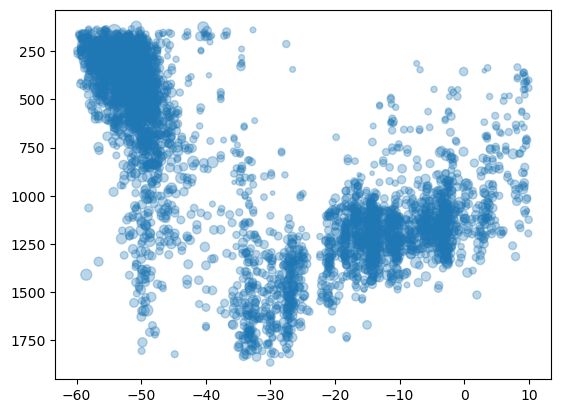

In [21]:

df_dc_pure = df_dc_pure.sample(frac=0.3, random_state=42)
plt.scatter(
    df_dc_pure["lat"],
    df_dc_pure["depth"],
    s=np.sqrt(df_dc_pure["thickness"])*10,
    alpha=0.3
)

plt.gca().invert_yaxis()
plt.show()

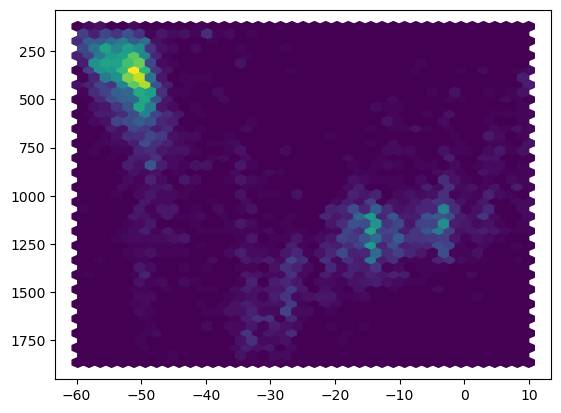

In [22]:
plt.hexbin(
    df_dc_pure["lat"],
    df_dc_pure["depth"],
    gridsize=40
)

plt.gca().invert_yaxis()
plt.show()